# Import needed modules

In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [ ]:
!kaggle datasets download -d die9origephit/nike-adidas-and-converse-imaged

Dataset URL: https://www.kaggle.com/datasets/die9origephit/nike-adidas-and-converse-imaged
License(s): CC0-1.0
 77% 12.0M/15.6M [00:00<00:00, 21.8MB/s]
100% 15.6M/15.6M [00:00<00:00, 16.7MB/s]


In [ ]:
!unzip nike-adidas-and-converse-imaged.zip

Archive:  nike-adidas-and-converse-imaged.zip
  inflating: test/adidas/0.jpg       
  inflating: test/adidas/1.jpg       
  inflating: test/adidas/10.jpg      
  inflating: test/adidas/11.jpg      
  inflating: test/adidas/12.jpg      
  inflating: test/adidas/13.jpg      
  inflating: test/adidas/14.jpg      
  inflating: test/adidas/15.jpg      
  inflating: test/adidas/16.jpg      
  inflating: test/adidas/17.jpg      
  inflating: test/adidas/18.jpg      
  inflating: test/adidas/19.jpg      
  inflating: test/adidas/2.jpg       
  inflating: test/adidas/20.jpg      
  inflating: test/adidas/21.jpg      
  inflating: test/adidas/22.jpg      
  inflating: test/adidas/23.jpg      
  inflating: test/adidas/24.jpg      
  inflating: test/adidas/25.jpg      
  inflating: test/adidas/26.jpg      
  inflating: test/adidas/27.jpg      
  inflating: test/adidas/28.jpg      
  inflating: test/adidas/29.jpg      
  inflating: test/adidas/3.jpg       
  inflating: test/adidas/30.jpg      
  in

# Data Preprocessing

**Read data and store it in dataframe**

In [ ]:
train_dir = '/content/train'
filepaths = []
labels = []

folds = os.listdir(train_dir)
for fold in folds:
    foldpath = os.path.join(train_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
train_df

,filepaths,labels
0,/content/train/nike/173.jpg,nike
1,/content/train/nike/93.jpg,nike
2,/content/train/nike/184.jpg,nike
3,/content/train/nike/244.jpg,nike
4,/content/train/nike/39.jpg,nike
...,...,...
706,/content/train/adidas/234.jpg,adidas
707,/content/train/adidas/224.jpg,adidas
708,/content/train/adidas/90.jpg,adidas
709,/content/train/adidas/209.jpg,adidas


In [ ]:
# Generate  test data paths with labels
test_dir = '/content/test'
filepaths = []
labels = []

folds = os.listdir(test_dir)
for fold in folds:
    foldpath = os.path.join(test_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
test_df

,filepaths,labels
0,/content/test/nike/6.jpg,nike
1,/content/test/nike/20.jpg,nike
2,/content/test/nike/3.jpg,nike
3,/content/test/nike/11.jpg,nike
4,/content/test/nike/14.jpg,nike
...,...,...
109,/content/test/adidas/28.jpg,adidas
110,/content/test/adidas/2.jpg,adidas
111,/content/test/adidas/27.jpg,adidas
112,/content/test/adidas/30.jpg,adidas


**Split dataframe into train, valid, and test**

In [ ]:
# valid and test dataframe
valid_df, test_df = train_test_split(test_df,  train_size= 0.6, shuffle= True, random_state= 123)

**Create image data generator**

In [ ]:
# image
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 711 validated image filenames belonging to 3 classes.
Found 68 validated image filenames belonging to 3 classes.
Found 46 validated image filenames belonging to 3 classes.


**Show sample from train data**

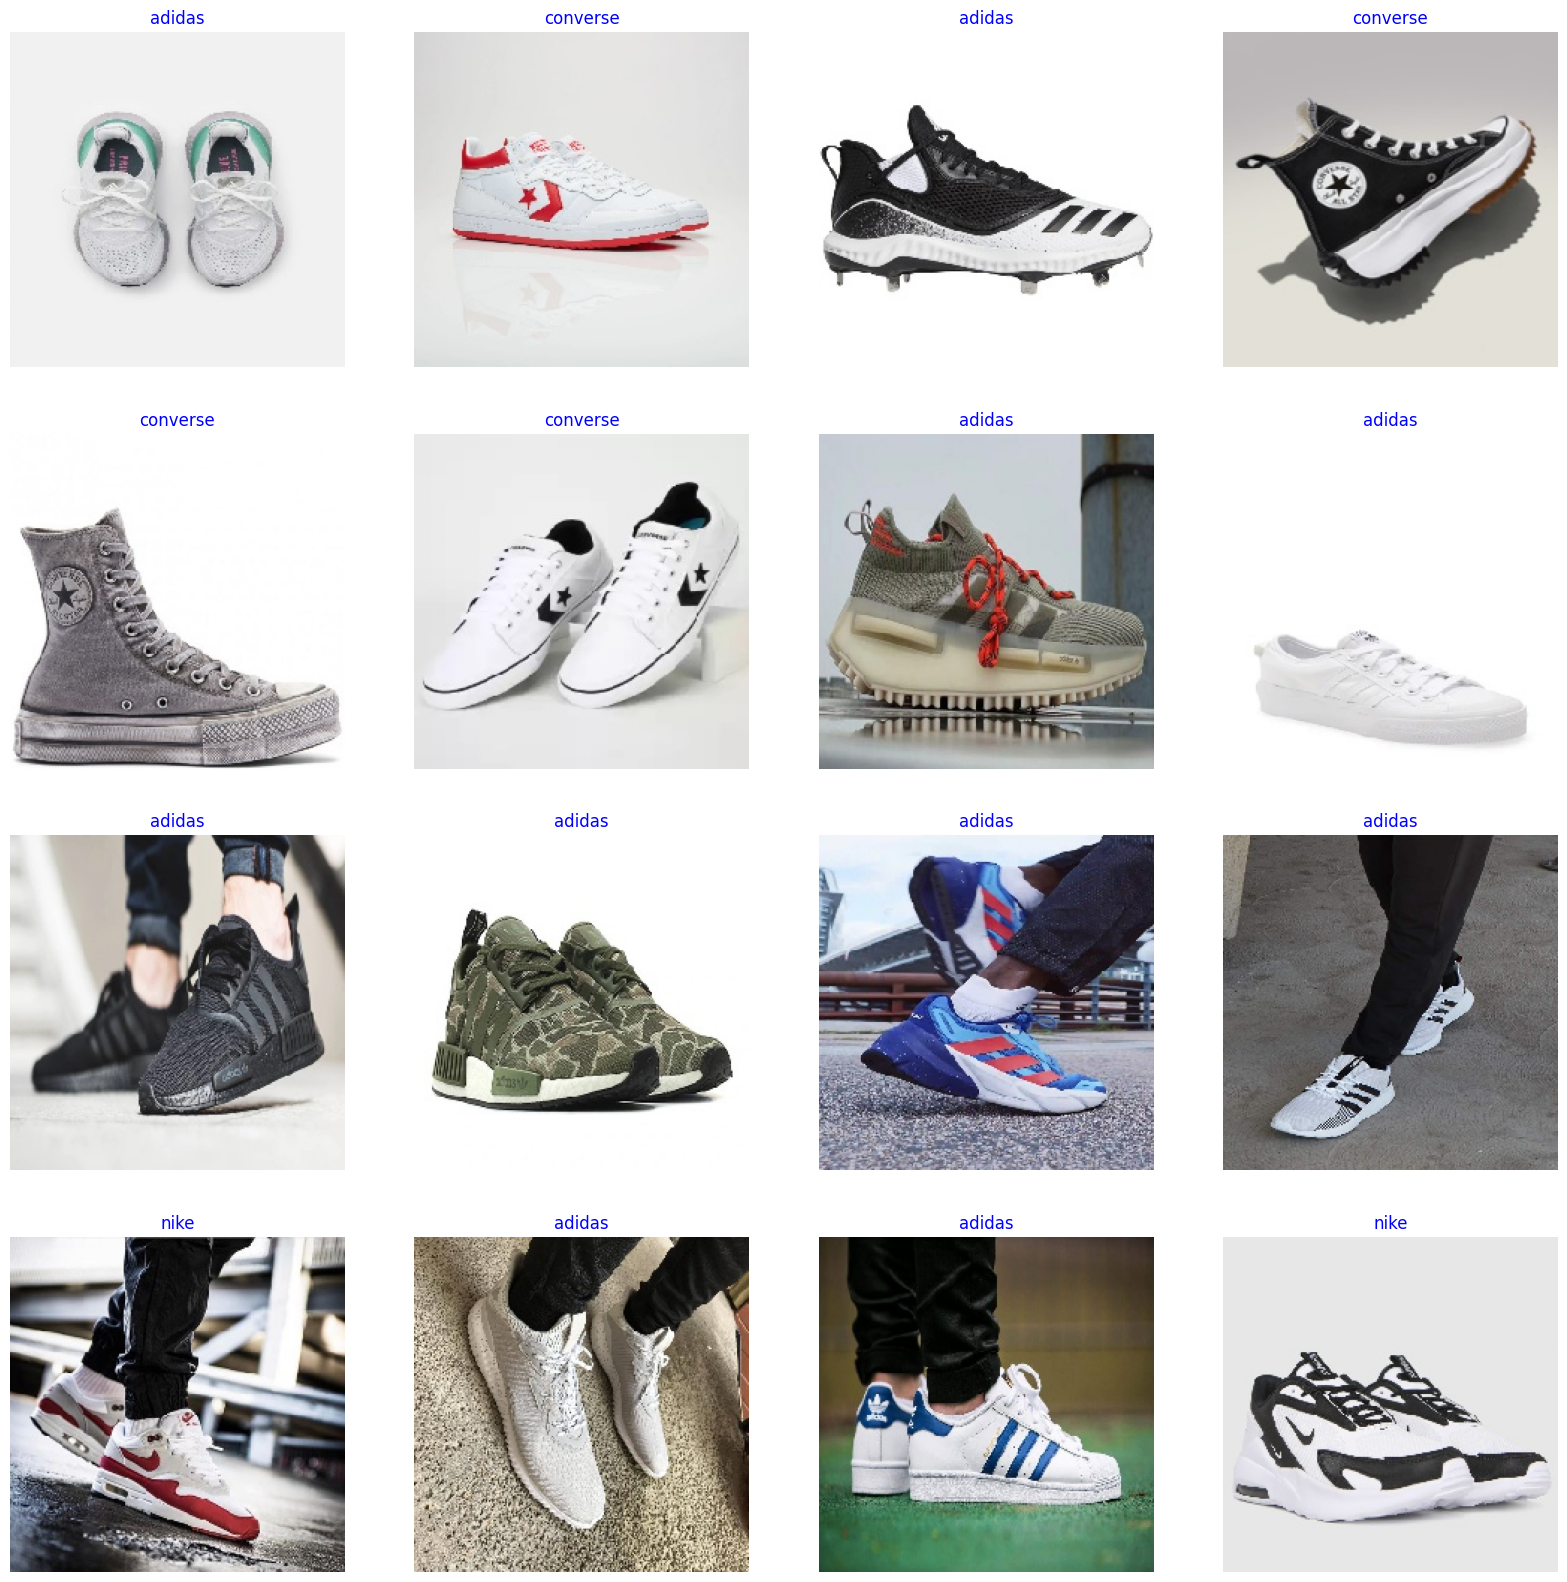

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# Model Structure

**Generic Model Creation**

In [ ]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

16705208/16705208 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                         

**Train model**

In [ ]:
batch_size = 20   # set batch size for training
epochs =  20  # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,validation_steps= None, shuffle= False)

Epoch 1/20
45/45 [==============================] - 72s 338ms/step - loss: 8.3859 - accuracy: 0.6146 - val_loss: 9.1831 - val_accuracy: 0.6471
Epoch 2/20
45/45 [==============================] - 12s 267ms/step - loss: 6.9802 - accuracy: 0.8790 - val_loss: 7.3867 - val_accuracy: 0.8235
Epoch 3/20
45/45 [==============================] - 9s 191ms/step - loss: 6.3322 - accuracy: 0.9212 - val_loss: 6.3609 - val_accuracy: 0.8824
Epoch 4/20
45/45 [==============================] - 13s 296ms/step - loss: 5.7985 - accuracy: 0.9381 - val_loss: 5.7067 - val_accuracy: 0.9118
Epoch 5/20
45/45 [==============================] - 11s 237ms/step - loss: 5.2830 - accuracy: 0.9578 - val_loss: 5.1947 - val_accuracy: 0.9118
Epoch 6/20
45/45 [==============================] - 11s 251ms/step - loss: 4.8374 - accuracy: 0.9761 - val_loss: 4.8158 - val_accuracy: 0.8971
Epoch 7/20
45/45 [==============================] - 10s 234ms/step - loss: 4.4408 - accuracy: 0.9691 - val_loss: 4.4193 - val_accuracy: 0.9265


**Display model performance**

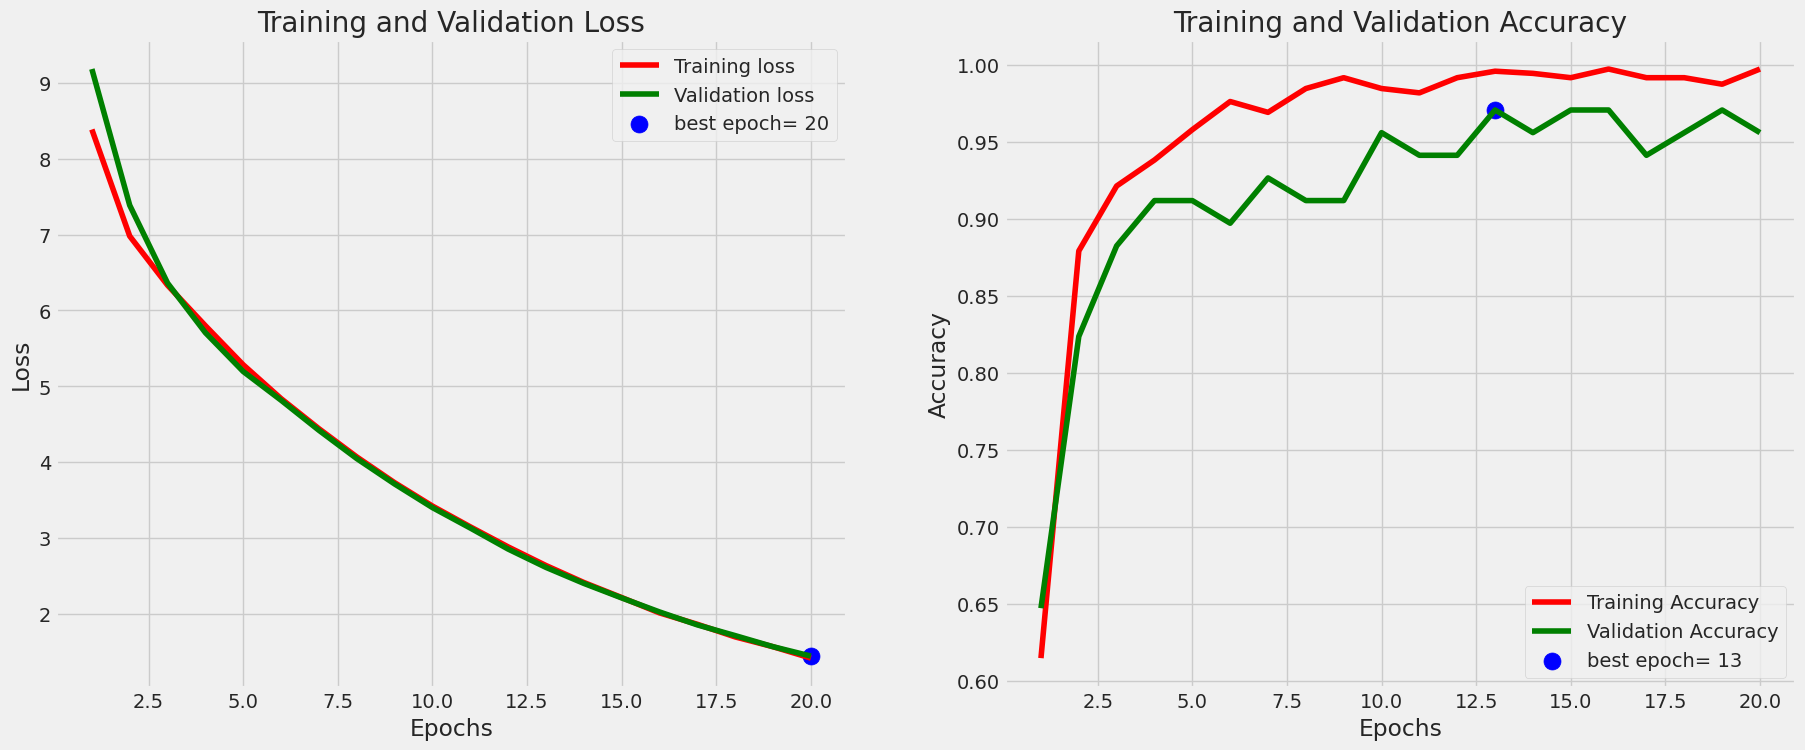

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show()

# Evaluate model

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 [==============================] - 0s 105ms/step - loss: 1.7589 - accuracy: 0.8125
Train Loss:  1.316543459892273
Train Accuracy:  1.0
--------------------
Validation Loss:  1.3252190351486206
Validation Accuracy:  1.0
--------------------
Test Loss:  1.758923888206482
Test Accuracy:  0.8125


**Get Predictions**

In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

**Confusion Matrics and Classification Report**

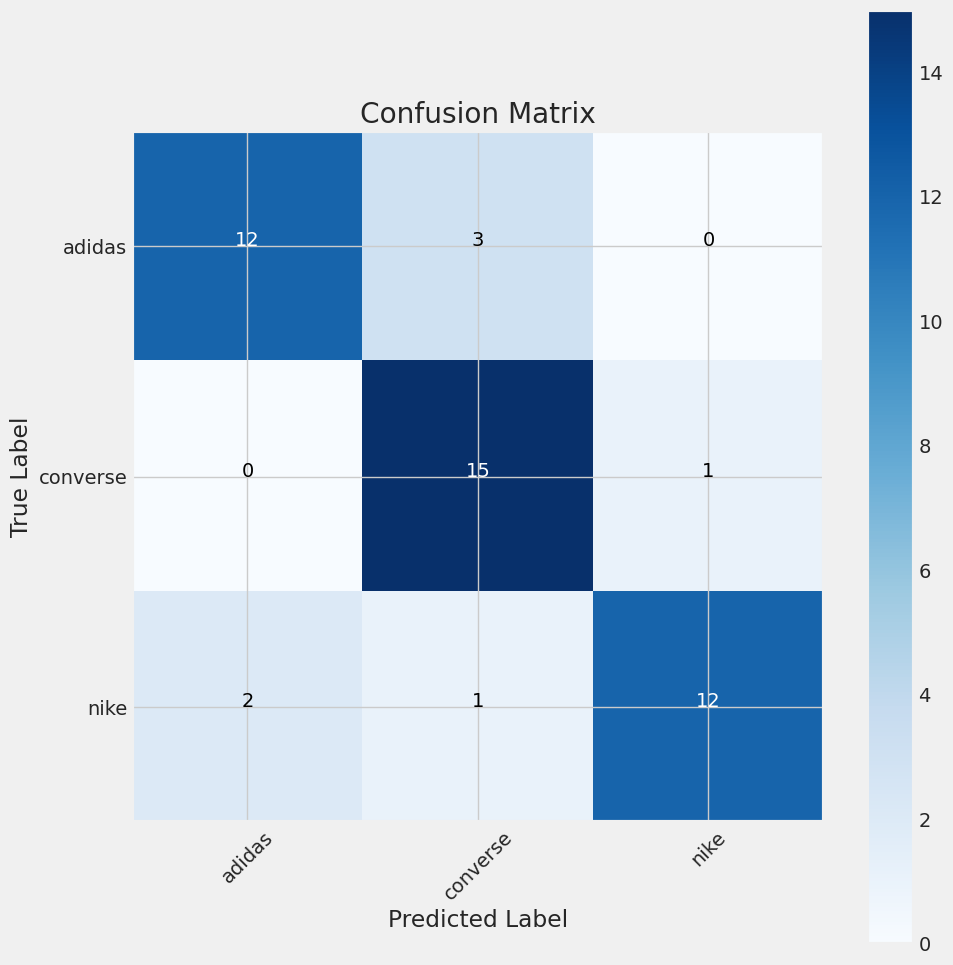

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      adidas       0.86      0.80      0.83        15
    converse       0.79      0.94      0.86        16
        nike       0.92      0.80      0.86        15

    accuracy                           0.85        46
   macro avg       0.86      0.85      0.85        46
weighted avg       0.86      0.85      0.85        46



**Save model**

In [ ]:
#Save the model
model.save('model.h5')

# Prediction using loaded_model

In [ ]:
loaded_model = tf.keras.models.load_model('/content/model.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
image_path = '/content/adi'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 0s 433ms/step
adidas
